In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    )
)
print(model)


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D

In [3]:
model = model.to(device)
sum([p.numel() for p in model.parameters()])

1707009

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 6, 1, 8, 1, 0, 9, 2])


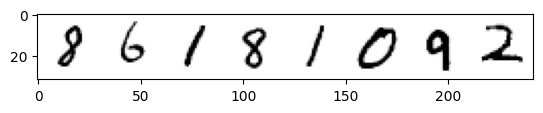

In [4]:
dataset = torchvision.datasets.MNIST(root="./MNIST/", train=True, download=True,
                                     transform=torchvision.transforms.ToTensor())  #载入数据集
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  #设置数据加载器
x, y = next(iter(train_dataloader))  #取出1个batch的图像和标签
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")  #用plt展示每个batch图像组成的网格

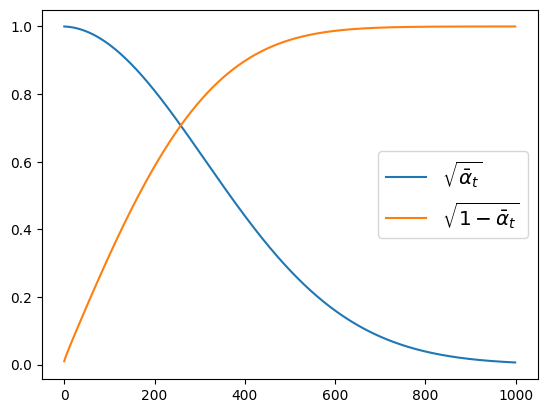

In [5]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"${\sqrt{1-\bar{\alpha}_t}}$")
plt.legend(fontsize="x-large")

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

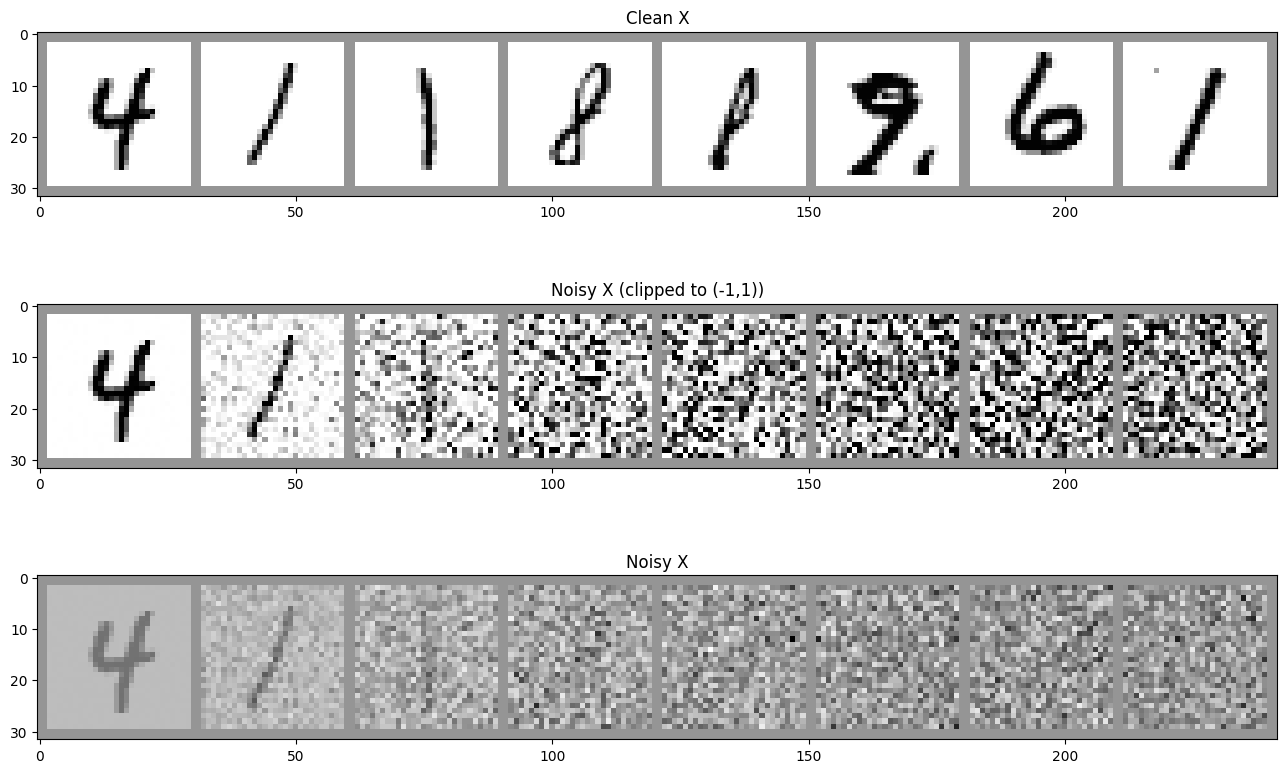

In [6]:
# 可视化:DDPM加噪过程中的不同时间步
# 对一批图片加噪,看看效果
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1.  # 映射到(-1,1)
print("X shape", xb.shape)

# 展示干净的原始输入
axs[0].imshow(torchvision.utils.make_grid(xb)[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

# 使用调度器加噪
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

# 展示带"带噪"版本(使用或不使用截断函数clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb)[0].detach().cpu().clip(-1, 1), cmap="Greys")
axs[1].set_title("Noisy X (clipped to (-1,1))")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb)[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")

In [7]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps)[0]
model_prediction.shape

torch.Size([8, 1, 28, 28])

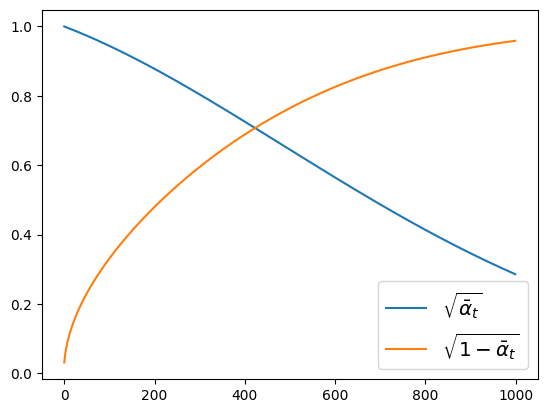

In [8]:
# 仅添加了少量噪声
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"${\sqrt{1-\bar{\alpha}_t}}$")
plt.legend(fontsize="x-large")

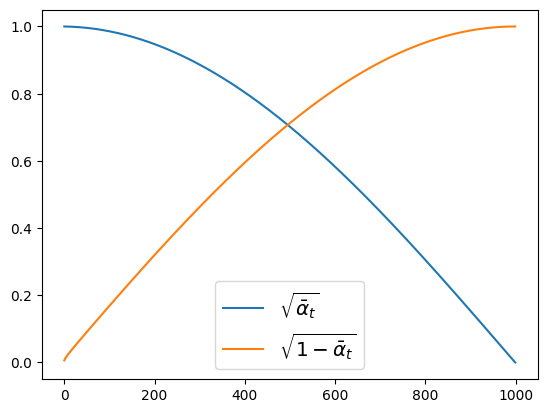

In [9]:
# "cosine"调度方式,这种方式可能更适合尺寸较小的图像
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"${\sqrt{1-\bar{\alpha}_t}}$")
plt.legend(fontsize="x-large")

In [15]:
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))

938


In [16]:
# 设定噪声调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for i, batch in enumerate(train_dataloader):
        print("batch",i)
        clean_images = batch[0].to(device)
        # 为图片添加噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # 为每张图片随机采样一个时间步
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()

        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # 获取模型的预测结果
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # 迭代模型参数
        optimizer.step()
        optimizer.zero_grad()

        if (epoch + 1) % 5 == 0:
            loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
            print(f"Epoch:{epoch + 1},losses:{loss_last_epoch}")



batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))  #对数坐标轴
plt.show()
